# **Step 1: Loading Libraries and  Exploring Dataset**


Dataset Head:
                                           Statement      Status
0  life doesn’t feel worth it that’s kind of it? ...  Depression
1  This life sucks and if it were for my religiou...  Depression
2  its been 9 months now for our marriage and she...      Stress
3  I do not feel particularly sad or anxious or a...  Depression
4  I am taking Venlafaxine. it is an SSRI. does n...  Depression

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  36876 non-null  object
 1   Status     37130 non-null  object
dtypes: object(2)
memory usage: 580.3+ KB
None

Missing Values:
Statement    254
Status         0
dtype: int64
Missing Values Per Class:
                      Statement  Status
Status                                 
Anxiety                      30       0
Bipolar                      73       0
Depression          

C:\Users\user\AppData\Local\Temp\ipykernel_3272\1388860206.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())


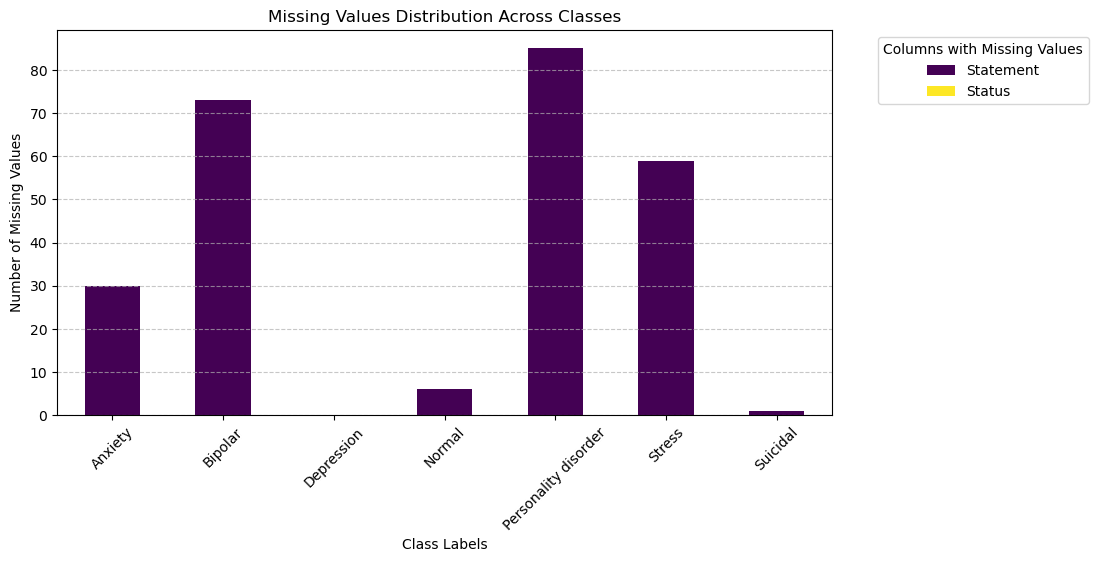

Number of Instances Per Class:
Status
Normal                  11446
Depression              10783
Suicidal                 7457
Anxiety                  2721
Bipolar                  2014
Stress                   1868
Personality disorder      841
Name: count, dtype: int64


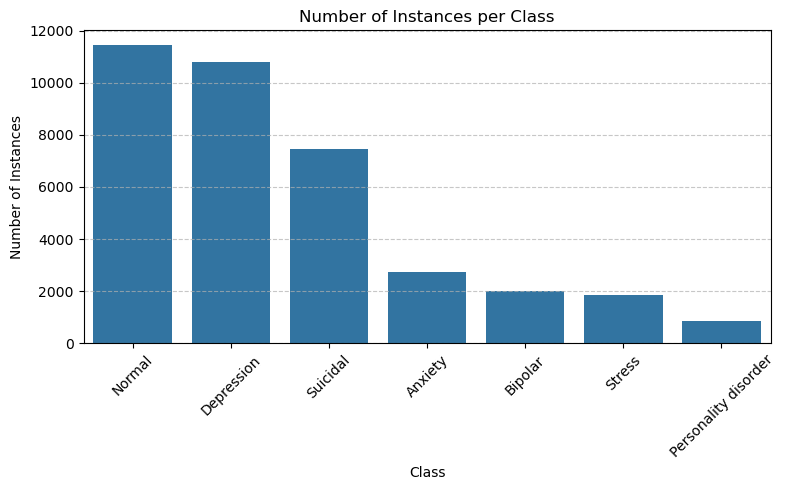

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df_adjusted = pd.read_csv("Sentiment_analysis_dataset.csv")
# Inspect Data
print("Dataset Head:")
print(df_adjusted.head())
print("\nDataset Info:")
print(df_adjusted.info())

# Check for Missing Values
print("\nMissing Values:")
print(df_adjusted.isnull().sum())

# Check for missing values per class
missing_values_per_class = df_adjusted.groupby("Status").apply(lambda x: x.isnull().sum())

# Display missing values per class
print("Missing Values Per Class:")
print(missing_values_per_class)

# Plot Bar Graph
missing_values_per_class.plot(kind='bar', figsize=(10, 5), stacked=True, colormap='viridis')
plt.title("Missing Values Distribution Across Classes")
plt.xlabel("Class Labels")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.legend(title="Columns with Missing Values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Count instances per class
class_counts = df_adjusted['Status'].value_counts()

# Print number of instances per class
print("Number of Instances Per Class:")
print(class_counts)

# Plot number of instances per class
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Instances per Class")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Count instances per class
class_counts = df_adjusted['Status'].value_counts()


**AUGMENTING SEGMENT**

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import random

# --- Preprocessing: Drop rows with missing 'Statement'
before_drop = df_adjusted.shape[0]
df_adjusted.dropna(subset=['Statement'], inplace=True)
df_adjusted.reset_index(drop=True, inplace=True)
after_drop = df_adjusted.shape[0]
print(f"Rows before drop: {before_drop}")
print(f"Rows after drop: {after_drop}")
print(f"Total rows dropped: {before_drop - after_drop}")

# --- Download necessary resources if not already done
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')  # Download the missing resource

# --- Define Augmentation Functions

def get_synonyms(word):
    """Return a list of synonyms for a given word using WordNet."""
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            possible_syn = lemma.name().replace("_", " ")
            if possible_syn.lower() != word.lower() and possible_syn not in synonyms:
                synonyms.append(possible_syn)
    return synonyms

def synonym_augmentation(text, p=0.3):
    """
    Replace words in the text with synonyms with probability p.
    This helps introduce variability into your dataset.
    """
    words = word_tokenize(text)
    augmented_words = []
    for w in words:
        # With probability p, try replacing the word with one of its synonyms.
        if random.random() < p:
            syns = get_synonyms(w)
            if syns:
                new_w = random.choice(syns)
                augmented_words.append(new_w)
            else:
                augmented_words.append(w)
        else:
            augmented_words.append(w)
    return " ".join(augmented_words)

def augment_texts(text, num_aug=1, p=0.3):
    """Generate multiple augmented samples from one text."""
    return [synonym_augmentation(text, p=p) for _ in range(num_aug)]


# --- Adjusting Class Distributions

# Set a target count for each class (e.g., 9000)
target_count = 9000

# DataFrame to hold the adjusted (undersampled and augmented) data
df_adjusted = pd.DataFrame()

# List to collect new augmented samples for minority classes
augmented_samples = []

# Get the counts per class from the current DataFrame
class_counts = df_adjusted['Status'].value_counts()
print("Original class counts:")
print(class_counts)

for cls, count in class_counts.items():
    # Subset of the current class
    subset = df_adjusted[df_adjusted['Status'] == cls]

    if count > target_count:
        # For majority classes, undersample to the target count
        subset = subset.sample(n=target_count, random_state=42)
        print(f"Undersampled '{cls}' from {count} to {target_count} instances.")
    elif count < target_count:
        # For minority classes, keep the original subset and generate additional augmented samples
        needed = target_count - count
        aug_per_row = needed // count  # how many augmentations per row
        remainder = needed % count     # leftover augmentations

        print(f"Augmenting '{cls}': {count} instances, need {needed} additional samples (≈{aug_per_row} per row with {remainder} remainder).")

        for idx, row in subset.iterrows():
            original_text = row['Statement']
            # Generate multiple augmented samples for each original text
            aug_texts = augment_texts(original_text, num_aug=aug_per_row, p=0.3)
            for aug_text in aug_texts:
                new_row = row.copy()
                new_row['Statement'] = aug_text
                augmented_samples.append(new_row)
            # Use remainder: assign one extra augmentation to some rows until the remainder is exhausted
            if remainder > 0:
                remainder -= 1
                aug_text = augment_texts(original_text, num_aug=1, p=0.3)[0]
                new_row = row.copy()
                new_row['Statement'] = aug_text
                augmented_samples.append(new_row)

    # Append the (undersampled or original) subset for this class
    df_adjusted = pd.concat([df_adjusted, subset], ignore_index=True)

# If any augmented samples were generated, append them as well
if augmented_samples:
    augmented_df = pd.DataFrame(augmented_samples)
    df_adjusted = pd.concat([df_adjusted, augmented_df], ignore_index=True)

# Optionally, shuffle the new adjusted DataFrame
df_adjusted = df_adjusted.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print("\nAdjusted dataset shape:", df_adjusted.shape)
print("New class counts after undersampling and augmentation:")
print(df_adjusted['Status'].value_counts())


Rows before drop: 37130
Rows after drop: 36876
Total rows dropped: 254


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original class counts:
Status
Normal                  11440
Depression              10783
Suicidal                 7456
Anxiety                  2691
Bipolar                  1941
Stress                   1809
Personality disorder      756
Name: count, dtype: int64
Undersampled 'Normal' from 11440 to 9000 instances.
Undersampled 'Depression' from 10783 to 9000 instances.
Augmenting 'Suicidal': 7456 instances, need 1544 additional samples (≈0 per row with 1544 remainder).
Augmenting 'Anxiety': 2691 instances, need 6309 additional samples (≈2 per row with 927 remainder).
Augmenting 'Bipolar': 1941 instances, need 7059 additional samples (≈3 per row with 1236 remainder).
Augmenting 'Stress': 1809 instances, need 7191 additional samples (≈3 per row with 1764 remainder).
Augmenting 'Personality disorder': 756 instances, need 8244 additional samples (≈10 per row with 684 remainder).

Adjusted dataset shape: (63000, 2)
New class counts after undersampling and augmentation:
Status
Stress      

# **Step 2: Data preprocessing and Baseline Performance**

Part 1: Cleaning the data


In [3]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re



# Download stopwords if not already downloaded
nltk.download('stopwords')
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

df_adjusted['Statement'] = df_adjusted['Statement'].apply(stemming)
df_adjusted.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Statement,Status
0,knew atom number scari would pray indium front...,Stress
1,mkkkkkkkkkk q doideira,Normal
2,felic feel like repres allot berth along late ...,Bipolar
3,skeptic diagnos constitut diagnos number physi...,Bipolar
4,serious everyth mean rhyme reason god use cope...,Suicidal




Part 2: Solving the imbalance with different techniques then running logistic regression





[Baseline (Train)] Accuracy: 0.8632
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.90      0.89      0.89      7200
             Bipolar       0.95      0.90      0.93      7200
          Depression       0.75      0.73      0.74      7200
              Normal       0.86      0.94      0.90      7200
Personality disorder       0.93      0.96      0.94      7200
              Stress       0.88      0.86      0.87      7200
            Suicidal       0.77      0.76      0.76      7200

            accuracy                           0.86     50400
           macro avg       0.86      0.86      0.86     50400
        weighted avg       0.86      0.86      0.86     50400



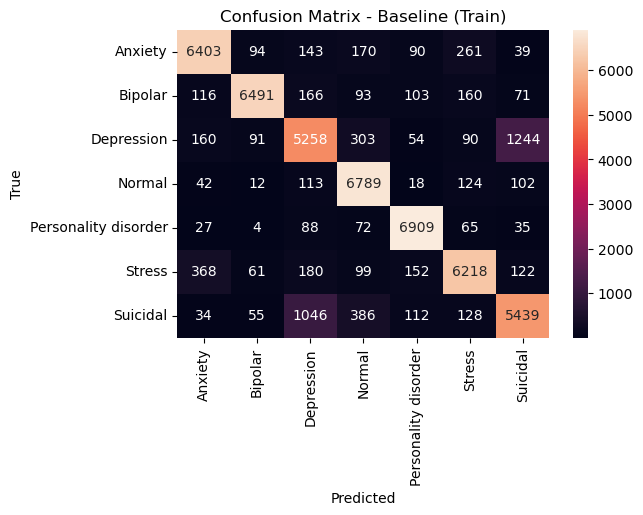


[Baseline] Accuracy: 0.8106
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.85      0.84      0.84      1800
             Bipolar       0.93      0.84      0.88      1800
          Depression       0.67      0.66      0.67      1800
              Normal       0.82      0.92      0.87      1800
Personality disorder       0.89      0.92      0.91      1800
              Stress       0.81      0.81      0.81      1800
            Suicidal       0.70      0.69      0.69      1800

            accuracy                           0.81     12600
           macro avg       0.81      0.81      0.81     12600
        weighted avg       0.81      0.81      0.81     12600



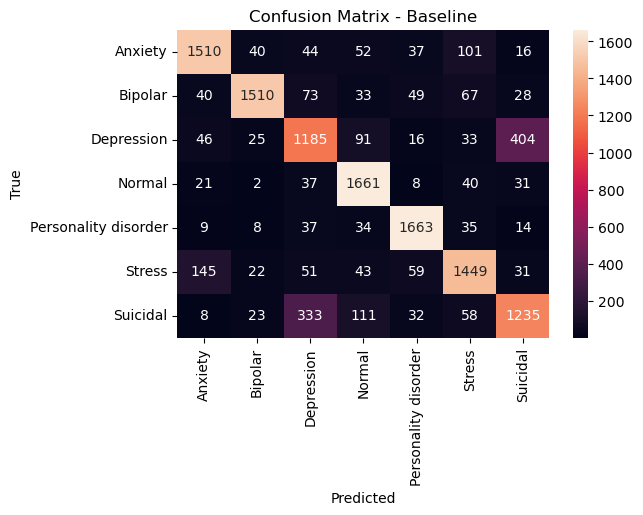

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

###############################################################################
# 1) DATA PREPARATION: LABEL ENCODING & TRAIN/TEST SPLIT
###############################################################################
# Encode the target variable
le = LabelEncoder()
df_adjusted['label'] = le.fit_transform(df_adjusted['Status'])

# Split the dataset into training and testing sets (using original imbalanced data)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_adjusted['Statement'], df_adjusted['label'], test_size=0.2, random_state=42, stratify=df_adjusted['label']
)

###############################################################################
# 2) TF-IDF VECTORIZATION (FIT ON TRAINING DATA ONLY)
###############################################################################
# Initialize TF-IDF Vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Fit TF-IDF on the training text and transform both training and test text
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

###############################################################################
# 3) HELPER FUNCTION: EVALUATE MODEL
###############################################################################

def evaluate_model(model, X_test, y_test, approach_name):
    """
    Print Accuracy, Classification Report, and plot Confusion Matrix.
    """
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[{approach_name}] Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {approach_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

###############################################################################
# 4) BASELINE MODEL: LOGISTIC REGRESSION
###############################################################################

# Train a Logistic Regression model on the training set without any balancing
model_baseline = LogisticRegression(max_iter=1000)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate the baseline model on the test set
evaluate_model(model_baseline, X_train_tfidf, y_train, "Baseline (Train)")
evaluate_model(model_baseline, X_test_tfidf, y_test, "Baseline")


# **Step 3: Trying Random Forests**


=== RandomForest Train Evaluation ===
Accuracy: 0.9987
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       1.00      1.00      1.00      7200
             Bipolar       1.00      1.00      1.00      7200
          Depression       1.00      1.00      1.00      7200
              Normal       0.99      1.00      1.00      7200
Personality disorder       1.00      1.00      1.00      7200
              Stress       1.00      1.00      1.00      7200
            Suicidal       1.00      1.00      1.00      7200

            accuracy                           1.00     50400
           macro avg       1.00      1.00      1.00     50400
        weighted avg       1.00      1.00      1.00     50400



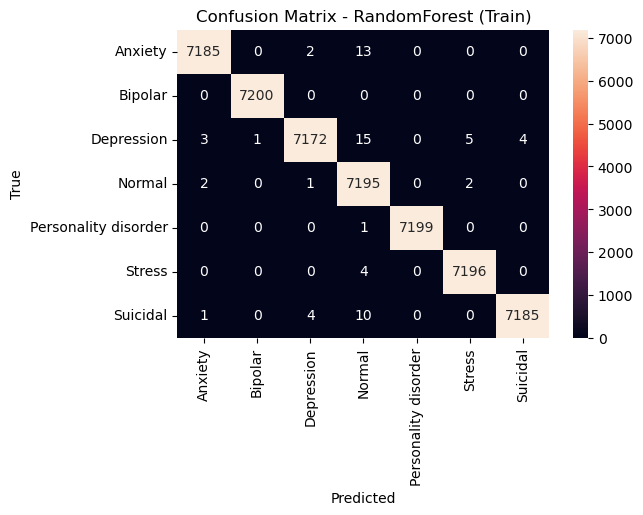


=== RandomForest Test Evaluation' ===
Accuracy: 0.8177
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.89      0.87      0.88      1800
             Bipolar       0.94      0.87      0.91      1800
          Depression       0.65      0.66      0.65      1800
              Normal       0.83      0.92      0.88      1800
Personality disorder       0.91      0.95      0.93      1800
              Stress       0.84      0.85      0.84      1800
            Suicidal       0.67      0.60      0.63      1800

            accuracy                           0.82     12600
           macro avg       0.82      0.82      0.82     12600
        weighted avg       0.82      0.82      0.82     12600



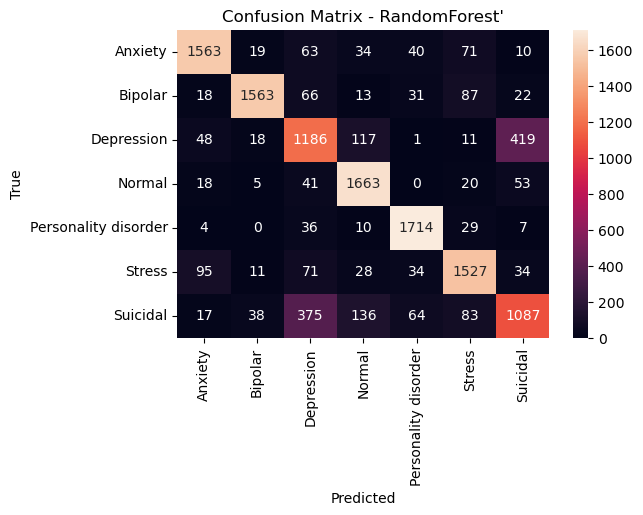

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########################################
# Approach 2: Random Forest with Randomized Search
########################################

# Define hyperparameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,              # Try 10 random combinations
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit to training data
random_search_rf.fit(X_train_tfidf, y_train)

# Best model
best_rf = random_search_rf.best_estimator_

# Show best params
print("=== Best Hyperparameters for RandomForest ===")
print(random_search_rf.best_params_)

# ==== Evaluate on Training Set ====
y_pred_train = best_rf.predict(X_train_tfidf)
print("\n=== RandomForest Train Evaluation ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_train, y_pred_train)))
print("Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=le.classes_))

cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest (Train)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==== Evaluate on Test Set ====
y_pred_test = best_rf.predict(X_test_tfidf)
print("\n=== RandomForest Test Evaluation ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_test)))
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [7]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

###############################################################################
# 6) XGBOOST WITH RANDOMIZED SEARCH FOR HYPERPARAMETER TUNING
###############################################################################

# 6.1) Define distributions of hyperparameters to sample from
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# 6.2) Initialize base model
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 6.3) Randomized search setup
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,                # 🔁 Try only 10 random combinations
    scoring='accuracy',       # Can be changed to 'f1_weighted' if needed
    cv=3,                     # 3-fold cross-validation for speed
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6.4) Fit randomized search
random_search.fit(X_train_tfidf, y_train)

# 6.5) Best estimator
best_xgb_model = random_search.best_estimator_

# 6.6) Evaluate
print("\n=== XGBoost Best Model from Randomized Search ===")
print("Best Hyperparameters:", random_search.best_params_)

evaluate_model(best_xgb_model, X_train_tfidf, y_train, "XGBoost (Randomized Search - Train)")
evaluate_model(best_xgb_model, X_test_tfidf, y_test, "XGBoost (Randomized Search)")




Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

###############################################################################
# Evaluation Function for Best RandomizedSearchCV Model
###############################################################################
def evaluate_best_keras_model(grid_search, X_test, y_test, approach_name):
    best_model = grid_search.best_estimator_.model_
    history = grid_search.best_estimator_.history_

    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{approach_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    y_pred_probs = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{approach_name} - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{approach_name} - Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

###############################################################################
# Model Builder with Variable Number of Hidden Layers
###############################################################################
def create_variable_depth_model(hidden_units=128, num_layers=1, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(num_features,)))
    model.add(Dropout(dropout))
    for _ in range(num_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

###############################################################################
# Randomized Search for Neural Network (Variable Depth)
###############################################################################
keras_clf = KerasClassifier(
    model=create_variable_depth_model,
    verbose=0
)

param_dist = {
    'model__hidden_units': [64, 128, 256],
    'model__num_layers': [1, 2, 3],
    'model__dropout': [0.2, 0.3, 0.5],
    'model__learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
    'epochs': [5, 10, 15]
}


random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42
)

# Fit to training data
random_search.fit(X_train_tfidf, y_train)

# Show best model results
print("\n=== Best Neural Network from Randomized Search ===")
print("Best Parameters:", random_search.best_params_)
evaluate_best_keras_model(random_search, X_test_tfidf, y_test, "Best NN (Randomized Search)")




Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: Invalid parameter num_layers for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(num_layers=1)`
Check the list of available parameters with `estimator.get_params().keys()`